In [1]:
%pip -q install numpy pandas matplotlib scikit-learn h5py

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\yongz\Documents\ICT2211\Nature energy - code\.venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
import scipy.io
import scipy.stats
import sklearn.metrics
from sklearn import linear_model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Read Data Files

Read the processed dataset from `features_combined.csv` in the `Data` folder

In [9]:
featFileName = "../Data/features_combined.csv"
batch_pd = pd.read_csv(featFileName, index_col=False)
batch_pd

,policy,barcode,cycle_life,QD2,QD(Max-2),QD100,QDiffMin,QDiffMean,QDiffVar,QDiffSkew,QDiffKurtosis,QDiffStart,R3Coef,R3Intercept,R1Coef,R1Intercept,QDiffLinVar
0,3_6C-80PER_3_6C,???,1189.0,1.070689,0.468365,1.075913,-2.072648,-2.541602,-5.014861,-0.274041,0.129790,-4.261444,-0.000210,1.091262,0.000039,1.072078,-5.013791
1,3_6C-80PER_3_6C,???,1178.0,1.075301,0.009288,1.080630,-1.958457,-2.387257,-5.013960,-0.367163,0.012464,-3.803325,0.000006,1.080945,-0.000041,1.084710,-5.017121
2,3_6C-80PER_3_6C,???,1176.0,1.079922,0.008131,1.084940,-1.764058,-2.348070,-4.737000,0.033502,-0.457627,-5.056484,0.000011,1.084826,-0.000044,1.089331,-4.734378
3,4C-80PER_4C,???,1225.0,1.079723,0.006530,1.084750,-1.722149,-2.127507,-4.442613,-0.357486,0.039579,-3.739833,0.000018,1.084053,-0.000003,1.085031,-4.438865
4,4C-80PER_4C,???,1226.0,1.078417,0.005900,1.082646,-1.855177,-2.240332,-4.647744,-0.440634,0.125101,-4.380559,0.000020,1.081850,-0.000033,1.085851,-4.642574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,6C_31PER_4_25C,???,462.0,1.073565,0.007075,1.079078,-1.226029,-1.547619,-3.394968,-1.993884,0.134112,-4.417652,0.000013,1.078951,-0.000031,1.082138,-3.391890
76,6C_40PER_4C,???,457.0,1.070887,0.006366,1.076360,-1.244632,-1.577172,-3.452581,-1.389835,0.111612,-4.012170,0.000023,1.075190,-0.000017,1.078153,-3.453071
77,6C_4PER_4_75C,???,487.0,1.070473,0.005186,1.073041,-1.361351,-1.680775,-3.688418,-1.539699,0.113010,-4.279524,-0.000006,1.074844,-0.000079,1.080819,-3.691468
78,6C_52PER_3_5C,???,429.0,1.072614,0.007384,1.079520,-1.219913,-1.521692,-3.368943,-1.205534,0.132095,-4.142284,0.000030,1.077609,-0.000013,1.080783,-3.369759


Extract only the input features used by this model as a numpy array of features.

In [11]:
feat = batch_pd.drop(['policy','barcode','cycle_life','QDiffLinVar'], axis=1).to_numpy()
feat

array([[ 1.07068920e+00,  4.68365200e-01,  1.07591260e+00, ...,
         1.09126183e+00,  3.90283333e-05,  1.07207769e+00],
       [ 1.07530120e+00,  9.28830000e-03,  1.08062970e+00, ...,
         1.08094533e+00, -4.06916667e-05,  1.08471002e+00],
       [ 1.07992230e+00,  8.13120000e-03,  1.08494040e+00, ...,
         1.08482585e+00, -4.38450000e-05,  1.08933135e+00],
       ...,
       [ 1.07047260e+00,  5.18560000e-03,  1.07304080e+00, ...,
         1.07484368e+00, -7.90550000e-05,  1.08081930e+00],
       [ 1.07261380e+00,  7.38420000e-03,  1.07951970e+00, ...,
         1.07760921e+00, -1.25166667e-05,  1.08078345e+00],
       [ 1.04213750e+00,  8.11270000e-03,  1.04702290e+00, ...,
         1.04935858e+00, -8.31183333e-05,  1.05527146e+00]])

Extract the battery policy and cycle life. Battery policy will be used to identify 'fast charging' and 'slow charging' batteries, while cycle life is used as training labels.

In [12]:
bat_info = batch_pd.loc[:,'policy':'cycle_life']

## Features
The Discharge Model uses 13 features.

In [13]:
# quoted: "data fix"
feat[0,9] = 1.692e-5;
feat[0,10] = 1.0750;

feat[14,1] = 0.00397;
feat[14,9] = -4.8296e-5;
feat[14,10] = 1.0705;

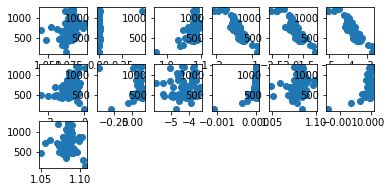

In [15]:
for i in range(feat.shape[1]):
    plt.subplot(4, 6, i+1)
    plt.scatter(feat[:,i], bat_info["cycle_life"])

plt.show()

## Data Preparation
Functions for splitting dataset into training and testing dataset, and normalization.

In [16]:
def train_test_split(feat_in, label_in):
    '''
    As the name implies, split the training data and associated labels
    by allocating every other sample into the test set and the rest to the train set
    '''
    return {
        "feat_train": feat_in[0::2],
        "feat_test": feat_in[1::2],
        "label_train": label_in[0::2],
        "label_test": label_in[1::2]
    }

In [16]:
def feat_scale(feat_set):
    '''Normalize the training and testing data into standard normal distribution'''
    return {
        "feat_train_scaled": scipy.stats.zscore(
            feat_set["feat_train"]
        ),
        "feat_test_scaled": scipy.stats.zmap(
            feat_set["feat_test"],
            feat_set["feat_train"]
        )
    }

## Model Building
SKLearn Least Squares linear regression model with Elastic Net as regularization and Four-Fold Cross Validation.

In [19]:
class Model:
    '''Linear Elastic Net with Four-Fold Cross-Validation, alpha = 0.9'''
    def __init__(self, name="model"):
        self.model = linear_model.ElasticNetCV(cv=4, l1_ratio=0.9)
        self.name = name

    def train_model(self, feat_in, label_in):
        '''
        provide entire dataset to this function as feats and label arrays\n
        this function will perform train/test splitting and normalization
        before training the model.
        '''
        self.dataset = train_test_split(feat_in, label_in)
        self.scaled_feats = feat_scale(self.dataset)
        self.model.fit(
            self.scaled_feats["feat_train_scaled"],
            self.dataset["label_train"]
        )
        return self

    def predict(self):
        '''make predictions'''
        return {
            "ypred_train": self.model.predict(
                self.scaled_feats["feat_train_scaled"]
            ),
            "ypred_test": self.model.predict(
                self.scaled_feats["feat_test_scaled"]
            )
        }
    
    def metrics(self):
        '''compute RMSE of training and testing predictions'''
        ypreds = self.predict()
        return pd.DataFrame({
            "RMSE_train": [sklearn.metrics.mean_squared_error(
                self.dataset["label_train"],
                ypreds["ypred_train"],
                squared=False
            )],
            "RMSE_test": [sklearn.metrics.mean_squared_error(
                self.dataset["label_test"],
                ypreds["ypred_test"],
                squared=False
            )],
            "R2_train": [self.model.score(
                self.scaled_feats["feat_train_scaled"],
                self.dataset["label_train"]
            )],
            "R2_test": [self.model.score(
                self.scaled_feats["feat_test_scaled"],
                self.dataset["label_test"]
            )],
            "epochs": [
                self.model.n_iter_
            ]
        }, index=[self.name])

    def plot_accuracy(self):
        ypreds = self.predict()
        plt.plot(np.arange(2000),np.arange(2000))
        plt.scatter(
            self.dataset["label_train"],
            ypreds["ypred_train"],
            label="train", marker="o")
        plt.scatter(
            self.dataset["label_test"],
            ypreds["ypred_test"],
            label="test", marker="^")
        plt.legend()
        plt.show()
        
    def get_base_model(self):
        return self.model

In [36]:
# construct and train the linear model
# The variable name "B" is used to match the reference paper's code conventions.
B = Model(
    "Discharge Model (Whole Set)"
).train_model(feat, bat_info["cycle_life"])

## Evaluation

Training and testing RMSE and R2 Scores

In [37]:
# calculate prediction interval
B.metrics().transpose()

,Discharge Model (Whole Set)
RMSE_train,70.172594
RMSE_test,101.595032
R2_train,0.921435
R2_test,0.788128
epochs,84.000000


Graph to show the distance of predictions from perfection. Black line is the line of exact match between prediction and actual cycle life; below the line is an underestimation, above the line is an overestimation.

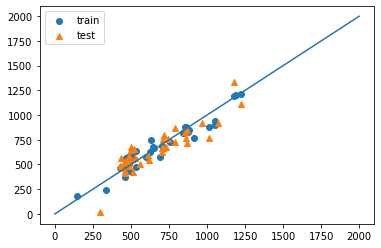

In [25]:
B.plot_accuracy()

## Create Base Models for comparison with Transfer Learning
Create two base models, one trained on normal charging, the other on fast charging.

In [25]:
# split dataset into normal charging and fast charging subsets
fast_charge_indices = bat_info['policy'].str.match("^[5-8].*C")
slow_charge_feat = feat[~fast_charge_indices]
slow_charge_label = bat_info["cycle_life"][~fast_charge_indices]
fast_charge_feat = feat[fast_charge_indices]
fast_charge_label = bat_info["cycle_life"][fast_charge_indices]

In [38]:
# train both base models
normal_charge_model = Model(
    "base model (norm charge)"
).train_model(slow_charge_feat, slow_charge_label)

fast_charge_model = Model(
    "base model (fast charge)"
).train_model(fast_charge_feat, fast_charge_label)

## Evaluate Base Models

In [21]:
pd.concat([
    normal_charge_model.metrics(),
    fast_charge_model.metrics()
])

,RMSE_train,RMSE_test,R2_train,R2_test,epochs
base model (norm charge),32.099531,266.750283,0.988114,0.286956,171
base model (fast charge),55.193670,85.076788,0.920004,0.740799,38


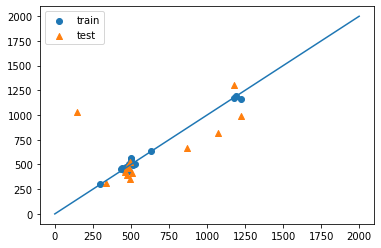

In [22]:
normal_charge_model.plot_accuracy()

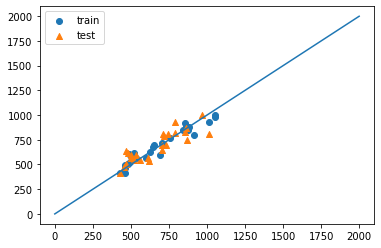

In [64]:
fast_charge_model.plot_accuracy()

## Export models to tensorflow


In [22]:
import tensorflow as tf

Create a tensorflow model to represent the same structure as the sklearn model

In [29]:
norm_tf_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=1)
])
norm_tf_model(normal_charge_model.scaled_feats["feat_train_scaled"])
norm_tf_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (15, 1)                   14        
                                                                 
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


Create a copy of the model for fast charging, making sure to reset the input shape configuration.  
(The input shape is detected when provided a training batch).

In [35]:
fast_tf_model = tf.keras.models.clone_model(
    norm_tf_model,
    input_tensors=tf.keras.layers.Input((13,))
)

Transfer learned weights from normal charging sklearn model to tensorflow model

In [36]:
base_model = normal_charge_model.get_base_model()
norm_tf_model.layers[0].weights[0].assign(base_model.coef_.transpose().reshape(-1,1))
norm_tf_model.layers[0].bias.assign([base_model.intercept_])

<tf.Variable 'UnreadVariable' shape=(1,) dtype=float32, numpy=array([623.13336], dtype=float32)>

Do the same for fast charging sklearn model

In [37]:
base_model = fast_charge_model.get_base_model()
fast_tf_model.layers[0].weights[0].assign(base_model.coef_.transpose().reshape(-1,1))
fast_tf_model.layers[0].bias.assign([base_model.intercept_])

<tf.Variable 'UnreadVariable' shape=(1,) dtype=float32, numpy=array([694.], dtype=float32)>

Tensorflow model must be compiled first before it will allow saving to file.

In [71]:
norm_tf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='mean_squared_error')

fast_tf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='mean_squared_error')

In [72]:
norm_tf_model.save('../discharge_model/saved_model/DischargeModelNormTF')
fast_tf_model.save('../discharge_model/saved_model/DischargeModelFastTF')

INFO:tensorflow:Assets written to: ./Data/DischargeModelNormTF\assets
INFO:tensorflow:Assets written to: ./Data/DischargeModelFastTF\assets
